In [1]:
import os
import numpy as np
import pandas as pd
import glob
from tqdm.auto import tqdm
from mmseg.apis import init_segmentor, inference_segmentor
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set up models

In [2]:
config_file = '../cache/upernet_originsize_convnext_base_fp16_256x256_160k_kaggle_25d_multilabel/upernet_originsize_convnext_base_fp16_256x256_160k_kaggle_25d_multilabel.py'
checkpoint_file = '../cache/upernet_originsize_convnext_base_fp16_256x256_160k_kaggle_25d_multilabel/best_mDice_iter_64000.pth'
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

/home/zhangzr/mmsegmentation_kaggle/mmseg/models/losses/cross_entropy_loss.py:238: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../cache/upernet_originsize_convnext_base_fp16_256x256_160k_kaggle_25d_multilabel/best_mDice_iter_64000.pth


# Utility

In [2]:
IMG_SIZE = [320, 384]
def load_img(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        img = np.pad(img, [pady, padx])
        # img = img.reshape((*resize))
        img = img.reshape((resize))
    return img, shape0

def load_imgs(img_paths, size=IMG_SIZE):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.float32)
    for i, img_path in enumerate(img_paths):
        if i==0:
            img, shape0 = load_img(img_path, size=size)
        else:
            img, _ = load_img(img_path, size=size)
        img = img.astype('float32') # original is uint16
        mx = np.max(img)
        if mx:
            img/=mx # scale image to [0, 1]
        imgs[..., i]+=img
    imgs = imgs*255
    return imgs.astype(np.uint8), shape0

In [3]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Make test submission csv

In [4]:
classes = ['large_bowel', 'small_bowel', 'stomach']
data_dir = "../input/uw-madison-gi-tract-image-segmentation/"
test_dir = os.path.join(data_dir, "test")
sub = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))
test_images = glob.glob(os.path.join(test_dir, "**", "*.png"), recursive = True)

if len(test_images) == 0:
    print('Can not find test images!!!!!!')
    test_dir = os.path.join(data_dir, "train")
    sub = pd.read_csv(os.path.join(data_dir, "train.csv"))[["id", "class"]].iloc[:100 * 3]
    sub["predicted"] = ""
    test_images = glob.glob(os.path.join(test_dir, "**", "*.png"), recursive = True)
    
id2img = {_.rsplit("/", 4)[2] + "_" + "_".join(_.rsplit("/", 4)[4].split("_")[:2]): _ for _ in test_images}
sub["file_name"] = sub.id.map(id2img)
sub["days"] = sub.id.apply(lambda x: "_".join(x.split("_")[:2]))
fname2index = {f + c: i for f, c, i in zip(sub.file_name, sub["class"], sub.index)}
sub

Can not find test images!!!!!!


,id,class,predicted,file_name,days
0,case123_day20_slice_0001,large_bowel,,../input/uw-madison-gi-tract-image-segmentatio...,case123_day20
1,case123_day20_slice_0001,small_bowel,,../input/uw-madison-gi-tract-image-segmentatio...,case123_day20
2,case123_day20_slice_0001,stomach,,../input/uw-madison-gi-tract-image-segmentatio...,case123_day20
3,case123_day20_slice_0002,large_bowel,,../input/uw-madison-gi-tract-image-segmentatio...,case123_day20
4,case123_day20_slice_0002,small_bowel,,../input/uw-madison-gi-tract-image-segmentatio...,case123_day20
...,...,...,...,...,...
295,case123_day20_slice_0099,small_bowel,,../input/uw-madison-gi-tract-image-segmentatio...,case123_day20
296,case123_day20_slice_0099,stomach,,../input/uw-madison-gi-tract-image-segmentatio...,case123_day20
297,case123_day20_slice_0100,large_bowel,,../input/uw-madison-gi-tract-image-segmentatio...,case123_day20
298,case123_day20_slice_0100,small_bowel,,../input/uw-madison-gi-tract-image-segmentatio...,case123_day20


# predict

  0%|          | 0/1 [00:00<?, ?it/s]

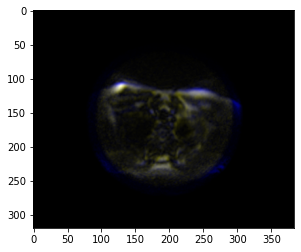

In [8]:
for day, group in tqdm(sub.groupby("days")):
    for file_name in group.file_name.unique():
        img = cv2.imread(file_name, cv2.IMREAD_ANYDEPTH)
        old_size = img.shape[:2]
        s = int(os.path.basename(file_name).split("_")[1])
        file_names = [file_name.replace(f"slice_{s:04d}", f"slice_{s + i:04d}") for i in range(-2, 3)]
        file_names = [_ for _ in file_names if os.path.exists(_)]
        file_names = [file_names[0], file_name, file_names[-1]]
        imgs, shape0 = load_imgs(file_names)
        res = inference_segmentor(model, imgs)[0]
        res = cv2.resize(res, old_size[::-1], interpolation = cv2.INTER_NEAREST)
        for j in range(3):
            rle = rle_encode(res[...,j])
            index = fname2index[file_name + classes[j]]
            sub.loc[index, "predicted"] = rle
        


# Format submission

In [10]:
sub = sub[["id", "class", "predicted"]]
sub.to_csv("submission.csv", index = False)
sub

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,
...,...,...,...
295,case123_day20_slice_0099,small_bowel,23815 5 24080 7 24120 6 24345 9 24377 4 24384 ...
296,case123_day20_slice_0099,stomach,
297,case123_day20_slice_0100,large_bowel,18243 2 18507 7 18517 5 18773 16 19039 17 1926...
298,case123_day20_slice_0100,small_bowel,23588 4 23815 5 23851 9 24080 7 24111 15 24345...
